# 1. Building an SIRH IPM with epymorph

Using epymorph's model definition features, we can construct an SIRH model with suitable parameters.

![SIRH model diagram](img/SIRH-diagram.png)

The differential equations for this model are as follows:

$$
\begin{aligned}
& \frac{dS}{dt} = -\frac{\beta S I}{N} + \xi R \\
& \frac{dI}{dt} = \frac{\beta S I}{N} - \gamma I \\
& \frac{dR}{dt} = (1 - h_p) \gamma I + \frac{H}{h_d} - \xi R \\
& \frac{dH}{dt} = h_p \gamma I - \frac{H}{h_d}
\end{aligned}
$$

Where $h_p$ and $h_d$ describes the probability of and expected duration of hospitalization, respectively.

In [1]:
from typing import Sequence

from sympy import Max

from epymorph import *
from epymorph.compartment_model import *
from epymorph.compartment_model import ModelSymbols
from epymorph.simulation import AttributeDef


class Sirh(CompartmentModel):
    compartments = [
        compartment("S"),
        compartment("I"),
        compartment("R"),
        compartment("H", tags=["immobile"]),
    ]

    requirements = [
        AttributeDef("beta", type=float, shape=Shapes.TxN),
        AttributeDef("gamma", type=float, shape=Shapes.TxN),
        AttributeDef("xi", type=float, shape=Shapes.TxN),
        AttributeDef("hospitalization_prob", type=float, shape=Shapes.TxN),
        AttributeDef("hospitalization_duration", type=float, shape=Shapes.TxN),
    ]

    def edges(self, symbols: ModelSymbols) -> Sequence[TransitionDef]:
        [S, I, R, H] = symbols.all_compartments
        [β, γ, ξ, h_prob, h_dur] = symbols.all_requirements

        # formulate N so as to avoid dividing by zero;
        # this is safe in this instance because if the denominator is zero,
        # the numerator must also be zero
        N = Max(1, S + I + R + H)

        return [
            edge(S, I, rate=β * S * I / N),
            fork(
                edge(I, H, rate=γ * I * h_prob),
                edge(I, R, rate=γ * I * (1 - h_prob)),
            ),
            edge(H, R, rate=H / h_dur),
            edge(R, S, rate=ξ * R),
        ]


sirh_ipm = Sirh()

Having built the IPM, we can now use it as the basis of a simple simulation.

Running simulation (BasicSimulator):
• 2015-01-01 to 2015-05-31 (150 days)
• 1 geo nodes
  |####################| 100%                    
Runtime: 0.018s


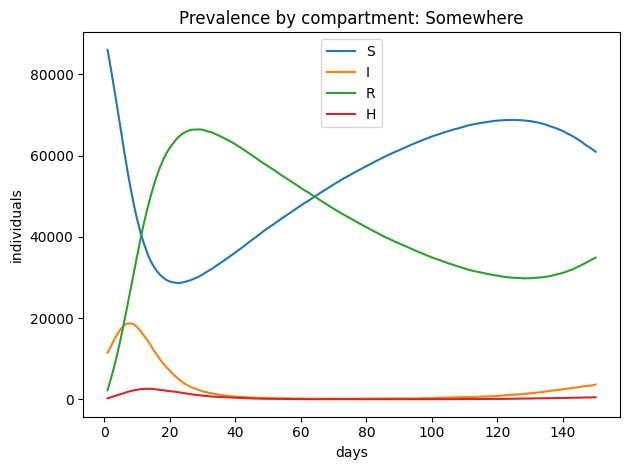

In [2]:
import numpy as np

from epymorph.geography.custom import CustomScope


rume = SingleStrataRume.build(
    ipm=sirh_ipm,
    mm=mm_library["no"](),
    scope=CustomScope(["Somewhere"]),
    params={
        "beta": 0.45,
        "gamma": 0.25,
        "xi": 0.0111,
        "hospitalization_prob": 0.1,
        "hospitalization_duration": 7.0,
        "population": np.array([100_000], dtype=SimDType),
    },
    time_frame=TimeFrame.of("2015-01-01", 150),
    init=init.SingleLocation(location=0, seed_size=10_000),
)

sim = BasicSimulator(rume)
with sim_messaging():
    output = sim.run()

plot_pop(output, pop_idx=0)